In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import calendar
from scipy.stats import chi2_contingency

In [2]:
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
import sys
import os

os.chdir(sys.path[3])

In [6]:
raw_data = pd.read_csv(r'data/process/new_data.csv', skiprows=[1, 2]).reset_index()

In [5]:
# Just for presentation
vv = pd.read_csv(r'data/process/new_data.csv', skiprows=[2]).reset_index()
vv.iloc[0].to_csv('questions_description')
vv

,index,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q33_9_TEXT,Q34,Q35,Q36,Q37,Q38,Q39,Q39_10_TEXT,Q40,Q40_3_TEXT
0,0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,What were the main reasons you cycled more oft...,In what year were you born?,What is your gender?,What is your annual household income after taxes?,How many bicycles do you currently own?,What is the highest level of education you hav...,What do you consider your main ethnic origin o...,What do you consider your main ethnic origin o...,Where did you hear about this survey? - Select...,Where did you hear about this survey? - Other ...
1,1,4/21/2022 14:05,4/21/2022 14:10,IP Address,169.231.161.135,100,318,TRUE,4/21/2022 14:10,R_sRQ635z5e2hc1t7,...,NaN,1996,Woman,"$200,000 or more per year",One,"Graduate degree (e.g., Master’s, Professional ...","European (e.g., British Isles, German, French,...",NaN,Email,NaN
2,2,4/14/2022 17:28,4/14/2022 17:41,IP Address,128.111.106.41,22,770,FALSE,4/21/2022 17:41,R_21uo7CnrNd8VNIx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4/21/2022 19:27,4/21/2022 19:31,IP Address,70.77.83.154,100,229,TRUE,4/21/2022 19:31,R_7V5ufQv2WtbkiSR,...,NaN,1973,Man,I prefer to not answer,Three,Bachelor’s degree (university 4-year degree) ...,"European (e.g., British Isles, German, French,...",NaN,"A bicycle registry/recovery system (e.g., Bike...",NaN
4,4,4/14/2022 19:04,4/14/2022 20:18,IP Address,70.185.131.128,22,4454,FALSE,4/21/2022 20:18,R_qPdUVtdN6wMTtIt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2021,6/6/2022 22:07,6/6/2022 22:14,IP Address,47.146.75.18,100,423,TRUE,6/6/2022 22:14,R_3fYRblhWSYPWCj8,...,NaN,1970,Woman,"Between $100,000 and $149,999 per year",Three,Bachelor’s degree (university 4-year degree) ...,"European (e.g., British Isles, German, French,...",NaN,Email,NaN
2022,2022,5/24/2022 12:17,5/24/2022 12:20,IP Address,174.90.223.242,69,191,FALSE,6/7/2022 12:20,R_3O7a8xS7l3i8EZG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,2023,6/8/2022 3:19,6/8/2022 3:30,IP Address,108.211.181.111,100,697,TRUE,6/8/2022 3:30,R_3gO85Ni57rH0pTr,...,NaN,NaN,Prefer not to say,I prefer to not answer,I prefer to not answer,"Graduate degree (e.g., Master’s, Professional ...",I prefer to not answer,NaN,Other (please specify):,acquientance
2024,2024,5/25/2022 13:39,5/25/2022 13:39,IP Address,50.205.153.166,2,12,FALSE,6/8/2022 13:39,R_1jwTkRmNyNow9Tz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



The questions we are going to use for the following model are stored in the cols variable. Q8 (What type of lock did you use to secure your bicycle? - Selected Choice) has been removed since it includes 951 Nun Values (that means 47% of participants didn't answer that question). The rest of the filtered questions have been removed since I thought they were irrelevant.

In [113]:
cols = ['index', 'Q2', 'Q6', 'Q7', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q17']
shrt_name = {'Q2':'part','Q4':'year','Q5':'month','Q6':'day_time','Q7':'is_locked','Q8':'locked_type','Q9':'theft_location','Q10':'is_regi','Q11':'report_loc','Q12':'is_insured','Q13':'estimate_val','Q14':'is_electric','Q15':'bike_type','Q17':'is_university','Q19':'is_online','Q21':'is_police_assist','Q23':'recovery_loc','Q24':'con_recovery','Q34': 'birth', 'Q35': 'gender', 'Q36': 'income', 'Q38': 'education', 'Q39': 'ethnic_origin'}

The code discards participants who answer more than three null questions

In [9]:
raw_features = raw_data[cols]
len(raw_features)
filtered_nun = raw_features[raw_features.count(axis=1) > 3]

1864

Below is a table showing the questions grouped by the same answer number

In [117]:
for col in cols[1:]:
    print(filtered_nun.groupby(by=col, dropna=False).count()['index'])

Q2
A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)      25
Entire bicycle (i.e., frame and components)                                             1824
NaN                                                                                       15
Name: index, dtype: int64
Q6
Afternoon (12:00-17:59)    362
Don’t know/not sure        337
Evening (18:00-23:59)      227
Morning (06:00-11:59)      176
Overnight (00:00-05:59)    753
NaN                          9
Name: index, dtype: int64
Q7
Don’t know/not sure                                               37
No, unlocked                                                     728
Yes, frame locked to a fixed structure (e.g., bike rack)         966
Yes, locked one or more wheels (i.e., bike locked to itself)     126
NaN                                                                7
Name: index, dtype: int64
Q9
Against a street sign, tree, or street furniture (e.g., lamppost, railing, bench, parking meter)    

### Missing Values

First, a table is created, sorted from the question with the most  possible answers and  highest number of  NuNs

In [128]:
temp_dic = {'question_number': [], 'nun_count': [], 'num_of_ans': []}
for col in cols[1:]:
    temp_groupby = filtered_nun.groupby(by=col, dropna=False).count()['index']
    for_num_of_ans = filtered_nun.groupby(by=col, dropna=True).count()['index']
    temp_dic['question_number'].append(temp_groupby.index.name)
    temp_dic['nun_count'].append(temp_groupby[[np.nan]][0])
    temp_dic['num_of_ans'].append(len(for_num_of_ans))
df_col_q_nun_count = DataFrame(temp_dic)
what_to_deal_first = df_col_q_nun_count.sort_values(by='nun_count')
what_to_deal_first.sort_values(by=['num_of_ans','nun_count'],inplace=True)
what_to_deal_first

,question_number,nun_count,num_of_ans
0,Q2,15,2
10,Q17,40,2
4,Q10,26,3
8,Q14,67,3
2,Q7,7,4
6,Q12,27,4
1,Q6,9,5
7,Q13,24,9
3,Q9,26,11
9,Q15,66,13


Encode the answers to the questions

In [25]:
encode_str = "encode_"
cols_encode = {col: encode_str + col for col in cols[1:]}
manual_encoding = [ 'Q6', 'Q7', 'Q13']

 Some columns should have manual encoding

In [21]:
q6_dic = {'Evening (18:00-23:59)': 3,
          'Morning (06:00-11:59)': 1,
          'Afternoon (12:00-17:59)': 2,
          'Overnight (00:00-05:59)': 4,
          'Don’t know/not sure': 0}
filtered_nun[encode_str + 'Q6'] = filtered_nun['Q6'].replace(q6_dic).fillna(-1).astype(int)

C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\3458403864.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q6'] = filtered_nun['Q6'].replace(q6_dic).fillna(-1).astype(int)


In [22]:
q7_dic = {'Yes, frame locked to a fixed structure (e.g., bike rack) ': 3,
          'No, unlocked ': 1,
          'Yes, locked one or more wheels (i.e., bike locked to itself) ': 2,
          'Don’t know/not sure': 0}
filtered_nun[encode_str + 'Q7'] = filtered_nun['Q7'].replace(q7_dic).fillna(-1).astype(int)


C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\2873978644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q7'] = filtered_nun['Q7'].replace(q7_dic).fillna(-1).astype(int)


In [23]:
q13_dic = {'$7000 or more ': 8,
           '$4000-6999       ': 7,
           '$2000-3999      ': 6,
           '$1000-$1999 ': 5,
           '$500-$999 ': 4,
           '$250-$499 ': 3,
           'Less than $250 ': 2,
           'Don’t know/not sure ': 0, 'I prefer to not answer': 1
           }
filtered_nun[encode_str + 'Q13'] = filtered_nun['Q13'].replace(q13_dic).fillna(-1).astype(int)


C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\2495687643.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[encode_str + 'Q13'] = filtered_nun['Q13'].replace(q13_dic).fillna(-1).astype(int)


Automatic Encoding. Each answer's encoding value is shown in the table below

In [26]:
auto_encoding = cols_encode.copy()
[auto_encoding.pop(key) for key in manual_encoding]
filtered_nun[list(auto_encoding.values())] = filtered_nun[list(auto_encoding.keys())].apply(
    lambda x: x.astype('category').cat.codes)
for col in cols_encode.items():
    col = list(col)
    print(filtered_nun[col].apply(lambda x: x.drop_duplicates()))

                                                   Q2  encode_Q2
0   A major bicycle part necessary for riding (i.e...          0
2        Entire bicycle (i.e., frame and components)           1
38                                                NaN         -1
                         Q6  encode_Q6
0     Evening (18:00-23:59)          3
2     Morning (06:00-11:59)          1
4   Afternoon (12:00-17:59)          2
6   Overnight (00:00-05:59)          4
16      Don’t know/not sure          0
40                      NaN         -1
                                                   Q7  encode_Q7
0   Yes, frame locked to a fixed structure (e.g., ...          3
3   Yes, locked one or more wheels (i.e., bike loc...          2
5                                       No, unlocked           1
23                                Don’t know/not sure          0
40                                                NaN         -1
                                                    Q9  encode_Q9
0          

C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\3652104360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[list(auto_encoding.values())] = filtered_nun[list(auto_encoding.keys())].apply(
C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\3652104360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nun[list(auto_encoding.values())] = filtered_nun[list(auto_encoding.keys())].apply(
C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\3652104360.py:3: SettingWithCopyWarning: 
A 

In [ ]:
# In case the encoding for a specific question is required
pair = ['Q6','encode_Q6']
test = filtered_nun[pair].apply(lambda x: x.drop_duplicates())
test.to_csv('{}.csv'.format(pair[0]))

,index,Q2,Q6,Q7,Q9,Q10,Q11,Q12,Q13,Q14,...,encode_Q7,encode_Q13,encode_Q2,encode_Q9,encode_Q10,encode_Q11,encode_Q12,encode_Q14,encode_Q15,encode_Q17
16,16,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, frame locked to a fixed structure (e.g., ...",Controlled-access bicycle room or enclosed bik...,Yes,The police,No,$4000-6999,​No,...,3,7,1,3,2,7,2,2,10,0
26,26,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, frame locked to a fixed structure (e.g., ...",Outdoor bike rack,No,The police,No,Less than $250,​No,...,3,2,1,7,1,7,2,2,10,1
27,27,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, locked one or more wheels (i.e., bike loc...",Other (please specify):,No,"The police ,A bicycle registry/recovery system...",Yes,$500-$999,​No,...,2,4,1,6,1,8,3,2,7,0
29,29,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, locked one or more wheels (i.e., bike loc...",Workplace office,No,Other (please specify):,No,$250-$499,​No,...,2,3,1,10,1,5,2,2,1,1
30,30,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, frame locked to a fixed structure (e.g., ...",Parking garage bike rack/railing/pipe/etc.,No,"A bicycle registry/recovery system (e.g., Bike...",No,$500-$999,​No,...,3,4,1,9,1,0,2,2,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,1980,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"No, unlocked",Parking garage bike rack/railing/pipe/etc.,No,"The police ,A bicycle registry/recovery system...",No,$500-$999,​No,...,1,4,1,9,1,8,2,2,12,0
1990,1990,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"Yes, frame locked to a fixed structure (e.g., ...",Other (please specify):,No,The police,No,$500-$999,​No,...,3,4,1,6,1,7,2,2,8,1
2003,2003,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"No, unlocked",Inside a shed/garage,No,I did not report the theft,No,$500-$999,​No,...,1,4,1,4,1,4,2,2,7,0
2004,2004,"Entire bicycle (i.e., frame and components)",Don’t know/not sure,"No, unlocked",Inside house/apartment,No,"A bicycle registry/recovery system (e.g., Bike...",No,$2000-3999,​No,...,1,6,1,5,1,0,2,2,0,0


By using a random forest tree, impute the missing values in the rest of the columns

## Sol 2

In [130]:
dic_sol_2 = {'question_number':[],'question':[],'number of predictors':[],'accuracy':[]}
sol2 = filtered_nun.copy()
clf = RandomForestClassifier(random_state=0)
for col in what_to_deal_first['question_number']:
    print(col)
    dic_sol_2['question_number'].append(col)
    dic_sol_2['question'].append(shrt_name[col])
    y_col = cols_encode[col]
    # Get only encode columns from the table
    pre_filter = sol2[list(cols_encode.values())]

    # get only rows with Nun (-1) in current cul
    pre_x = pre_filter[pre_filter[y_col] == -1].drop(columns=y_col)
    # Find columns with Nun values. That columns would not consider features
    res = pre_x[pre_x == -1].any()
    no_features_list = list(res[res == True].index)
    num_of_fet = len(cols) - 2 - len(no_features_list)
    print('number of features are:{}'.format(num_of_fet))
    dic_sol_2['number of predictors'].append(num_of_fet)
    x_predict = pre_x.drop(columns=no_features_list)
    features_labels = pre_filter.drop(columns=no_features_list)

    # Build the data for the prediction
    xy = features_labels[~features_labels[features_labels == -1].any(axis=1)]
    x = xy.drop(columns=y_col).to_numpy()
    y = xy[y_col].to_numpy()

    clf.fit(x, y)
    sol_2_score = clf.score(x,y).round(2)
    print(sol_2_score)
    dic_sol_2['accuracy'].append(sol_2_score)
    sol2.loc[sol2[y_col] == -1, y_col] = clf.predict(x_predict)
DataFrame(data=dic_sol_2).merge(right=what_to_deal_first,on='question_number').to_csv('missing_values.csv')
sol2

Q2
number of features are:8
1.0
Q17
number of features are:1
0.86
Q10
number of features are:4


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.63
Q14
number of features are:5
0.88
Q7
number of features are:9


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.92
Q12
number of features are:6
0.63
Q6
number of features are:10


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.91
Q13
number of features are:7
0.46
Q9
number of features are:8


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.64
Q15
number of features are:9
0.78
Q11
number of features are:10


C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Achituv\anaconda3\envs\ox\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.89


,index,Q2,Q6,Q7,Q9,Q10,Q11,Q12,Q13,Q14,...,encode_Q7,encode_Q13,encode_Q2,encode_Q9,encode_Q10,encode_Q11,encode_Q12,encode_Q14,encode_Q15,encode_Q17
0,0,A major bicycle part necessary for riding (i.e...,Evening (18:00-23:59),"Yes, frame locked to a fixed structure (e.g., ...",Outdoor bike rack,No,I did not report the theft,No,$250-$499,NaN,...,3,3,0,7,1,4,2,2,4,1
2,2,"Entire bicycle (i.e., frame and components)",Morning (06:00-11:59),"Yes, frame locked to a fixed structure (e.g., ...",Other (please specify):,No,"The police ,A bicycle registry/recovery system...",No,$1000-$1999,​No,...,3,5,1,6,1,10,2,2,0,0
3,3,"Entire bicycle (i.e., frame and components)",Evening (18:00-23:59),"Yes, locked one or more wheels (i.e., bike loc...",NaN,NaN,NaN,NaN,NaN,NaN,...,2,4,1,4,1,11,2,2,7,0
4,4,"Entire bicycle (i.e., frame and components)",Afternoon (12:00-17:59),"Yes, frame locked to a fixed structure (e.g., ...",Outdoor bike rack,Yes,The police,Yes,$2000-3999,​No,...,3,6,1,7,2,7,3,2,5,0
5,5,"Entire bicycle (i.e., frame and components)",Evening (18:00-23:59),"No, unlocked",Outdoor bike rack,No,"The police ,A bicycle registry/recovery system...",No,$500-$999,​No,...,1,4,1,7,1,8,2,2,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,2019,"Entire bicycle (i.e., frame and components)",Overnight (00:00-05:59),"No, unlocked","Outside in the yard or on a balcony, porch, or...",No,The police,Yes,$250-$499,​No,...,1,3,1,8,1,7,3,2,8,1
2020,2020,"Entire bicycle (i.e., frame and components)",Morning (06:00-11:59),"No, unlocked",Inside a shed/garage,No,The police,No,$1000-$1999,​No,...,1,5,1,4,1,7,2,2,8,0
2021,2021,"Entire bicycle (i.e., frame and components)",Evening (18:00-23:59),"No, unlocked",Inside a shed/garage,No,"The police ,A bicycle registry/recovery system...",No,$2000-3999,​No,...,1,6,1,4,1,10,2,2,8,0
2022,2022,"Entire bicycle (i.e., frame and components)",Afternoon (12:00-17:59),"Yes, frame locked to a fixed structure (e.g., ...",Other (please specify):,No,The police,No,$2000-3999,​No,...,3,6,1,6,1,7,2,2,10,0


## Decision Tree for Recovery

In [131]:
recovery_col = 'Q18'
recovery_col_encode = "encode_" + recovery_col
sol2[recovery_col] = raw_data[recovery_col]

In [132]:
print(sol2.groupby(by=recovery_col, dropna=False).count()['index'])

Q18
No                             1555
Yes (including if damaged)      281
NaN                              28
Name: index, dtype: int64


In [133]:
# Rows without recovery information should be discarded
pre_dt = sol2[sol2[recovery_col].notna()]
# Encode recovery (0 or 1)
pre_dt[recovery_col_encode] = pre_dt[recovery_col].astype('category').cat.codes
pre_dt.to_csv('data/process/data_for_tree.csv')

C:\Users\Achituv\AppData\Local\Temp\ipykernel_39252\2607121340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_dt[recovery_col_encode] = pre_dt[recovery_col].astype('category').cat.codes


Dimensionality Reduction

In [135]:
clf = DecisionTreeClassifier(random_state=0)
x_tree = pre_dt[list(cols_encode.values())].to_numpy()
y_tree = pre_dt[recovery_col_encode].to_numpy()
dt = clf.fit(x_tree, y_tree)

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(dt, prefit=True)
X_new = model.transform(x_tree)
# For results presentation of this part
dic_clf_0 = {'question_number':None,'question':None,'feature_importances':None}
dic_clf_0['question_number'] = cols[1:]
dic_clf_0['question'] = [shrt_name[col] for col in cols[1:]]
dic_clf_0['feature_importances'] =clf.feature_importances_.round(3)

In [141]:
pre_dt[list(cols_encode.values())]

,encode_Q2,encode_Q6,encode_Q7,encode_Q9,encode_Q10,encode_Q11,encode_Q12,encode_Q13,encode_Q14,encode_Q15,encode_Q17
0,0,3,3,7,1,4,2,3,2,4,1
2,1,1,3,6,1,10,2,5,2,0,0
4,1,2,3,7,2,7,3,6,2,5,0
5,1,3,1,7,1,8,2,4,2,8,1
6,1,4,1,4,1,10,3,7,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...
2019,1,4,1,8,1,7,3,3,2,8,1
2020,1,1,1,4,1,7,2,5,2,8,0
2021,1,3,1,4,1,10,2,6,2,8,0
2022,1,2,3,6,1,7,2,6,2,10,0


In [154]:
# Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_tree, test_size=0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
param_grid = {"criterion": ["gini", "entropy"],"splitter": ['best', 'random'],'max_features':['auto','sqrt','log2',None]}
clf = DecisionTreeClassifier(random_state=0)
search = HalvingGridSearchCV(clf, param_grid, resource='n_samples',random_state=0).fit(X_train, y_train)

# scores = cross_val_score(clf, X_train, y_train, cv=cv)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [156]:
search.best_score_

0.7751320772359624

In [157]:
search.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}

In [162]:
DataFrame(search.cv_results_).iloc[-2:]

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_splitter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
22,2,1467,0.001711,0.003422,0.0,0.0,gini,sqrt,best,"{'criterion': 'gini', 'max_features': 'sqrt', ...",...,0.775132,0.011472,1,0.944587,0.944587,0.940324,0.944634,0.944634,0.943753,0.001715
23,2,1467,0.000000,0.000000,0.0,0.0,gini,log2,best,"{'criterion': 'gini', 'max_features': 'log2', ...",...,0.775132,0.011472,1,0.944587,0.944587,0.940324,0.944634,0.944634,0.943753,0.001715


In [163]:
# Confusion Matrix
y_pred =search.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
cm = confusion_matrix(y_test,y_pred)
not_rec = tn/ (tn+fp)
rec = tp/ (tp+fn)
acc = (tn+tp)/(tn+fp+fn+tp)
print('cm is {} acc_not_rec is {} rec is {} acc is {}'.format(cm,not_rec,rec,acc))

cm is [[282  38]
 [ 40   8]] acc_not_rec is 0.88125 rec is 0.16666666666666666 acc is 0.7880434782608695


In [164]:
tn, fp, fn, tp

(282, 38, 40, 8)

In [165]:
clf2 = DecisionTreeClassifier(min_samples_split= 100,criterion= 'gini', max_features='sqrt', splitter= 'best')
clf2.fit(X_new, y_tree)

DecisionTreeClassifier(max_features='sqrt', min_samples_split=100)

In [28]:
# Tree Analysis

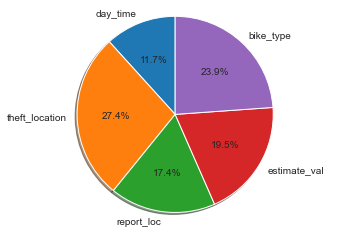

In [178]:
features_name= [ 'day_time', 'theft_location', 'report_loc', 'estimate_val', 'bike_type']
pie_df = DataFrame(data = {'features_name':features_name,'feature_importances':clf2.feature_importances_*100})
fig1, ax1 = plt.subplots()
ax1.pie(pie_df['feature_importances'], labels=pie_df['features_name'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.savefig('python/notebooks/pie.png')
# Equal aspect ratio ensures that pie is drawn as a circle.

In [171]:
pie_df

,features_name,feature_importances
0,day_time,11.719079
1,theft_location,27.437233
2,report_loc,17.427250
3,estimate_val,19.544655
4,bike_type,23.871782


### For DT interpretation

In [173]:
fig, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=500)
tree.plot_tree(clf2,
               feature_names= features_name,
               class_names=['no', 'yes'],
               filled=True,
               rounded= True
               )
fig.savefig('python/notebooks/output/new_tree_5.pdf')
feature_names_inter= [ 'Q6', 'Q9', 'Q11', 'Q13', 'Q15'],

In [110]:
# for the question number and its abbreviation
dic= {'Q2':'part','Q6':'day_time','Q7':'is_locked','Q8':'locked_type','Q9':'theft_location','Q10':'is_regi','Q11':'report_loc','Q12':'is_insured','Q13':'estimate_val','Q14':'is_electric','Q15':'bike_type','Q17':'is_university','Q19':'is_online','Q21':'is_police_assist','Q23':'recovery_loc','Q24':'con_recovery','Q34': 'birth', 'Q35': 'gender', 'Q36': 'income', 'Q38': 'education', 'Q39': 'ethnic_origin'}
df_test = DataFrame(index=dic.keys(),data=dic.values())
df_test.to_csv('test.csv')